# Property Recommender System
## Application of collaborative filtering using NMF in a Real Estate Recommender System
### The following python notebook uses a publicly available dataset of Real Estate transactions as a case study for recommending properties to existing real estate clients

#### Import necessary libraries

In [1]:
#import necessary libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF
import pandas as pd
from sklearn.cluster import DBSCAN
import folium
import requests
import time

#### Load the original dataset of the Real Estate Sales 730 Days
##### These data represents City of Hartford real estate sales for the years 2021 and 2022. Source: https://catalog.data.gov/dataset/real-estate-sales-730-days

In [2]:
df = pd.read_csv("../Data/US/Real_Estate_Sales_730_Days.csv")

#### Have look into the data

In [3]:
len(df)

4088

In [4]:

df.head(3)

,PropertyID,xrCompositeLandUseID,xrBuildingTypeID,ParcelID,LocationStartNumber,ApartmentUnitNumber,StreetNameAndWay,xrPrimaryNeighborhoodID,LandSF,TotalFinishedArea,...,OwnerLastName,OwnerFirstName,PrimaryGrantor,SaleDate,SalePrice,TotalAppraisedValue,LegalReference,xrSalesValidityID,xrDeedID,AssrLandUse
0,8347,7,16.0,278-816-169,938,0006,WETHERSFIELD AVE,236,NaN,654.00000,...,938 WETHERSFIELD AVE LLC,NaN,BROTHERS IN BLUE LLC,05/03/2022,176000,42100,07951-0127,25,10,CONDOMINIMUM
1,5053,4,11.0,229-649-035,55,NaN,CROWN ST,46,6960.0,2404.80001,...,LUNA,GUILLERMO,CORREA RANDY,08/05/2021,250000,233100,07806-0123,1,10,TWO FAMILY
2,4550,5,12.0,232-768-134,240,NaN,SOUTH ST,41,7500.0,3822.00000,...,ARAUJO,ROGER,PAZ DELIA M,02/07/2022,185000,200400,07905-0091,26,10,THREE FAMILY


##### Columns of the original dataset:

In [5]:
df.columns

Index(['PropertyID', 'xrCompositeLandUseID', 'xrBuildingTypeID', 'ParcelID',
       'LocationStartNumber', 'ApartmentUnitNumber', 'StreetNameAndWay',
       'xrPrimaryNeighborhoodID', 'LandSF', 'TotalFinishedArea', 'LivingUnits',
       'OwnerLastName', 'OwnerFirstName', 'PrimaryGrantor', 'SaleDate',
       'SalePrice', 'TotalAppraisedValue', 'LegalReference',
       'xrSalesValidityID', 'xrDeedID', 'AssrLandUse'],
      dtype='object')

* PropertyID: Unique identifier for each property. Typically used to reference a specific property in a database.

* xrCompositeLandUseID: A unique identifier relating to the classification or designation of the land use of the property, combining multiple land use aspects.

* xrBuildingTypeID: A unique identifier indicating the type of building on the property, e.g. single-family, multi-family, commercial.

* ParcelID: A unique identifier for a parcel of land assigned by the local tax assessor’s office.

* LocationStartNumber: Typically represents the street number in a property's address.

* ApartmentUnitNumber: If the property is an apartment building, this field indicates the specific unit number within the building.

* StreetNameAndWay: This represents the street name and type (e.g., Main St, Broadway Ave) of the property’s address.

* xrPrimaryNeighborhoodID: A unique identifier representing the neighborhood in which the property is located.

* LandSF: Represents the square footage of the land parcel.
TotalFinishedArea: Represents the total square footage of all finished areas within the property, typically including living spaces but excluding unfinished areas like garages or basements.

* LivingUnits: Number of individual living units within the property, especially relevant for multi-family buildings or apartment complexes.

* OwnerLastName: Last name of the property owner.

* OwnerFirstName: First name of the property owner.

* PrimaryGrantor: The person or entity who transferred ownership of the property, typically the seller in a sales transaction.

* SaleDate: The date on which the property was sold.

* SalePrice: The price at which the property was sold.

* TotalAppraisedValue: The estimated value of the property as determined by a property appraisal, often for taxation purposes.

* LegalReference: References legal documents or records pertaining to the property, including deed book and page number or other identifiers.

* xrSalesValidityID: A unique identifier representing the validity or type of the sales transaction, e.g., arms-length, non-arms-length.

* xrDeedID: A unique identifier for the deed associated with the property, indicating ownership and any encumbrances on the property.

* AssrLandUse: Represents the land use designation assigned by the assessor's office, indicating how the land is used (e.g., residential, commercial).

##### Remove irrelevant columns

In [6]:
columns_to_remove = [
    'LegalReference', 'ParcelID', 'xrDeedID', 'xrSalesValidityID','ApartmentUnitNumber',''
]

# Remove the irrelevant columns
for col in columns_to_remove:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

##### Combine first and last names

In [7]:
# Create a new column 'OwnerFullName' by combining 'OwnerLastName' and 'OwnerFirstName'
df['OwnerFullName'] = df['OwnerLastName'] + ', ' + df['OwnerFirstName']
# Drop the 'OwnerLastName' and 'OwnerFirstName' columns
df = df.drop(['OwnerLastName', 'OwnerFirstName'], axis=1)

#### Look into the distribution of purchases:

In [8]:
# Count the occurrences of each unique name
name_counts = df['OwnerFullName'].value_counts().reset_index()

# Rename the columns
name_counts.columns = ['OwnerFullName', 'Frequency']

# Sort the DataFrame based on the Frequency column in descending order
name_counts = name_counts.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

print(name_counts)

                 OwnerFullName  Frequency
0     GUJRAL, RANBIR S TRUSTEE         19
1        LEVINA, ELENA TRUSTEE         18
2                COOPER, NANCY         14
3              HERRERA, JHONNY          8
4                   STONE, RAE          7
...                        ...        ...
1987    BACKER, IVAN A TRUSTEE          1
1988           JAMES, CROSDALE          1
1989       FLORES SERRANO, LUZ          1
1990          ALEXANDER, URIAH          1
1991             ALLEN, ALDWIN          1

[1992 rows x 2 columns]


##### Replace the names with codes to anonymize the records

In [9]:
# Get a list of unique names
unique_names = df['OwnerFullName'].unique().tolist()

# Create a mapping of name to index
name_to_index = {name: index for index, name in enumerate(unique_names)}

df_anon = df.copy()
# Replace each name in 'OwnerFullName' with its index in the list of unique names
df_anon['OwnerFullName'] = df_anon['OwnerFullName'].map(name_to_index)

In [10]:
print("Number of unique names:",len(df_anon['OwnerFullName'].unique()))

Number of unique names: 1993


In [11]:
df_anon.head(3)

,PropertyID,xrCompositeLandUseID,xrBuildingTypeID,LocationStartNumber,StreetNameAndWay,xrPrimaryNeighborhoodID,LandSF,TotalFinishedArea,LivingUnits,PrimaryGrantor,SaleDate,SalePrice,TotalAppraisedValue,AssrLandUse,OwnerFullName
0,8347,7,16.0,938,WETHERSFIELD AVE,236,NaN,654.00000,1.0,BROTHERS IN BLUE LLC,05/03/2022,176000,42100,CONDOMINIMUM,0
1,5053,4,11.0,55,CROWN ST,46,6960.0,2404.80001,2.0,CORREA RANDY,08/05/2021,250000,233100,TWO FAMILY,1
2,4550,5,12.0,240,SOUTH ST,41,7500.0,3822.00000,3.0,PAZ DELIA M,02/07/2022,185000,200400,THREE FAMILY,2


##### Define the categorical fields

In [12]:
categorical_fields = ["StreetNameAndWay","xrCompositeLandUseID","xrBuildingTypeID","xrPrimaryNeighborhoodID","LivingUnits","AssrLandUse"]

In [13]:
df_encoded = df_anon[categorical_fields].copy()
df_encoded['OwnerFullName'] = df_anon['OwnerFullName']

##### Turn the categorical fields to one-hot-encodings

In [14]:
df_encoded = pd.get_dummies(df_encoded, columns=categorical_fields)

In [15]:
#scaler = MinMaxScaler()
#df_encoded['SalePrice'] = scaler.fit_transform(df_anon[['SalePrice']])
#df_encoded['TotalFinishedArea'] = scaler.fit_transform(df_anon[['TotalFinishedArea']])

##### Apply non-Negative matrix factorization

In [16]:
n_components = 200

NMF_model = NMF(n_components, init='random', random_state=0, max_iter=500)
#Calculate the NMF model based on the Train Set values. 
# the_train_Values.T = H.W

df_encoded.fillna(0, inplace=True)

tmp_df = df_encoded.drop(columns='OwnerFullName')

FF = NMF_model.fit(tmp_df.values)
 
# W =(1/H)*_sparseMatrix 
W = FF.transform(tmp_df.values)
 
#NMF_results: not sparse anymore
NMF_results = NMF_model.inverse_transform(W)

##### Make a dataframe out of the NMF results and add the encoded names to records.

In [17]:
df_encoded = pd.DataFrame(NMF_results,columns=tmp_df.columns)

In [18]:
df_encoded = pd.concat([df_anon['OwnerFullName'], df_encoded], axis=1)

##### Find out the top n=5 recommendations of the categorical field StreetNameAndWay for each record.

In [19]:
col = "StreetNameAndWay"

# Get the columns starting with the original column name (e.g., 'AREA_')
relevant_cols = [c for c in df_encoded.columns if c.startswith(col + '_')]

# Convert each relevant column to numeric separately.
for rel_col in relevant_cols:
    df_encoded[rel_col] = pd.to_numeric(df_encoded[rel_col], errors='coerce', downcast='integer')

def get_top_5(row):
    # Retrieve the top 5 columns and remove the prefix for each of them
    top_5_cols = row.nlargest(5).index.tolist()
    return ', '.join([item.replace(col + '_', '') for item in top_5_cols])

# Apply the function to the subset of the dataframe to get the top 5 columns and assign it to a new column
df_encoded[col + '_top_5'] = df_encoded[relevant_cols].apply(get_top_5, axis=1)


##### Remove one-hot-encoded fields

In [20]:
# Get columns to drop - those starting with a name from 'columns' followed by an underscore
# but NOT containing '_top_5'
cols_to_drop = [col for col in df_encoded.columns if any(col.startswith(original + '_') for original in categorical_fields) and '_top_5' not in col]

# Drop those columns
df_encoded = df_encoded.drop(columns=cols_to_drop)


##### Re-arrange the columns and get the missing ones from the original data

In [21]:
# Step 1: Determine the desired order of columns
ordered_columns = []
for col in df_encoded.columns:
    if col.endswith('_top_5'):
        base_col_name = col.replace('_top_5', '')
        ordered_columns.extend([base_col_name, col])

# Add any additional columns from df_encoded that are haven't added yet
for col in df_encoded.columns:
    if col not in ordered_columns:
        ordered_columns.append(col)

# Step 2: Copy the data from df_anon based on the ordering
for col in [c for c in ordered_columns if not c.endswith('_top_5')]:
    if col in df_anon.columns:
        df_encoded[col] = df_anon[col]

# Step 3: Rearrange columns in df_encoded based on the order in ordered_columns
df_encoded = df_encoded[ordered_columns]


In [22]:
df_encoded.columns

Index(['StreetNameAndWay', 'StreetNameAndWay_top_5', 'OwnerFullName'], dtype='object')

In [23]:
df_final = df_encoded[['OwnerFullName', 'StreetNameAndWay', 'StreetNameAndWay_top_5']]

##### Calculate the hit/success ratio of for each categorical field.

In [24]:
df_final['StreetNameAndWay_top_5'] = df_final['StreetNameAndWay_top_5'].str.split(',')

In [25]:
result = df_final.groupby('OwnerFullName').agg({
  'StreetNameAndWay': lambda x: list(set(x)),
  'StreetNameAndWay_top_5': lambda x: [city for sublist in x for city in sublist]
}).reset_index()

df_final = result

In [26]:
col = "StreetNameAndWay"
col_5 = 'StreetNameAndWay_top_5'
# Generate _hit column first

#df_final[col + '_hit'] = df_final.apply(lambda row: str(row[col]) in row[col + '_top_5'], axis=1)
df_final['StreetNameAndWay_hit'] = result.apply(lambda row: bool(set(row[col]) & set(row[col_5])), axis=1)

In [27]:
hf = "StreetNameAndWay_hit"
percentage_true = (df_final[hf].sum() / len(df_final)) * 100
print(hf, f": {percentage_true:.2f}%")

StreetNameAndWay_hit : 73.41%


In [28]:
print(df_final)

      OwnerFullName                                   StreetNameAndWay  \
0                 0  [HUNGERFORD ST, PUTNAM HTS, ARNOLD ST, ACTON S...   
1                 1                                         [CROWN ST]   
2                 2                                         [SOUTH ST]   
3                 3                                       [ALBANY AVE]   
4                 4                                    [CAMPFIELD AVE]   
...             ...                                                ...   
1988           1988                                       [BURNHAM ST]   
1989           1989                                        [ASHLEY ST]   
1990           1990                                  [WESTBOURNE PKWY]   
1991           1991                                       [MORTSON ST]   
1992           1992                                        [BURTON ST]   

                                 StreetNameAndWay_top_5  StreetNameAndWay_hit  
0     [WETHERSFIELD AVE,  FARMI

In [29]:
recs = df_final[df_final["OwnerFullName"] == 1989]["StreetNameAndWay_top_5"]
print(recs.values)

[list(['ASHLEY ST', ' SIGOURNEY ST', ' MAY ST', ' HUNTINGTON ST', ' WEST PRESTON ST'])]


##### Save the recommendation to a file

In [30]:
df_final.to_csv("Top_5_730_days_Recommendations.csv")

##### Show the original chioces of few randomly selected people and the recommendations to them on the map.

In [31]:
def nominatim_geocode(address):
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": address,
        "format": "json"
    }
    headers = {
        "User-Agent": "your_email@example.com"  # Replace this with your email
    }
    response = requests.get(base_url, params=params, headers=headers)
    data = response.json()
    if data:
        return float(data[0]['lat']), float(data[0]['lon'])
    else:
        return None

def show_addresses_and_recommendations(df, owner_names):
    m = folium.Map(location=[41.7637, -72.6851], zoom_start=13)  # Default Hartford coordinates
    
    # List of colors for the recommendations and original choices.
    colors = ['red', 'purple', 'orange', 'darkred', 'darkblue', 'darkgreen', 'blue']
    
    for index, owner_name in enumerate(owner_names):
        # Filter the dataframe for rows with the given owner name
        owner_df = df[df['OwnerFullName'] == owner_name]

        initials = owner_name  # Extract initials
        
        # address = f"{owner_df.iloc[0]['LocationStartNumber']} {owner_df.iloc[0]['StreetNameAndWay']}, Hartford, CT"
        # coordinates = nominatim_geocode(address)        
        # Mark the address (original choice)
        addresses = owner_df.iloc[0]['StreetNameAndWay']
        print(len(addresses), "addresses")
        iii = 0
        for address in addresses:
            
            address = f"{address}, Hartford, CT"
            print(address)
            coordinates = nominatim_geocode(address)
            color = colors[index % len(colors)]  # Assign color based on the index
            
            if coordinates:
                iii += 1
                # Use CircleMarker for the original choice with a bigger radius
                folium.CircleMarker(location=coordinates, 
                                    radius=16, 
                                    color=color, 
                                    fill_color=color, 
                                    fill=False, 
                                    fill_opacity=0.6, 
                                    tooltip=f"{owner_name}'s Address"
                                ).add_to(m)
                
                folium.Marker(coordinates, 
                            icon=folium.DivIcon(html=f"<div style='background-color: transparent; color: white;'>{initials}</div>")).add_to(m)
  
        # Mark the recommended streets with smaller circle markers
        recommended_streets = owner_df.iloc[0]['StreetNameAndWay_top_5']  # Assuming they are comma-separated
        for street in recommended_streets:
            recommended_address = f"{street.strip()}, Hartford, CT"
            recommended_coordinates = nominatim_geocode(recommended_address)
            if recommended_coordinates:
                folium.CircleMarker(location=recommended_coordinates, 
                                    radius=8, 
                                    color=color, 
                                    fill_color=color, 
                                    fill=True, 
                                    fill_opacity=0.6, 
                                    tooltip='Recommended Street for ' + str(owner_name)
                                   ).add_to(m)
                
                folium.Marker(recommended_coordinates, 
                              icon=folium.DivIcon(html=f"<div style='background-color: transparent; color: white;'>{initials}</div>")).add_to(m)
            
            time.sleep(1)  # Respect the rate limit of the API

    return m

# Example usage:
# Assuming 'df' is your dataframe and you want to visualize the data for a list of owners:
df_show = df_final[df_final["StreetNameAndWay"].apply(lambda x: len(x) > 1)].copy()

#df_show = df_final#.loc[df_final["StreetNameAndWay"].apply(lambda x: len(x) > 1)]

owner_names_list = df_show['OwnerFullName'].sample(5).tolist()
map_view = show_addresses_and_recommendations(df_show, owner_names_list)
map_view.save('owners_map.html')


2 addresses
WESTBOURNE PKWY, Hartford, CT
GARDEN ST, Hartford, CT
2 addresses
WILBUR ST, Hartford, CT
GIDDINGS ST, Hartford, CT
2 addresses
WETHERSFIELD AVE, Hartford, CT
EDGEWOOD ST, Hartford, CT
2 addresses
BARKER ST, Hartford, CT
FRANKLIN AVE, Hartford, CT
2 addresses
MORRIS ST, Hartford, CT
EVERGREEN AVE, Hartford, CT


In [32]:
df_final.head(3)

,OwnerFullName,StreetNameAndWay,StreetNameAndWay_top_5,StreetNameAndWay_hit
0,0,"[HUNGERFORD ST, PUTNAM HTS, ARNOLD ST, ACTON S...","[WETHERSFIELD AVE, FARMINGTON AVE, SUMNER ST...",True
1,1,[CROWN ST],"[WHITMORE ST, CROWN ST, JULIUS ST, BUSHNELL...",False
2,2,[SOUTH ST],"[SOUTH ST, CROMWELL ST, BALDWIN ST, FENWICK...",True


In [33]:
df_show.head(3)

,OwnerFullName,StreetNameAndWay,StreetNameAndWay_top_5,StreetNameAndWay_hit
0,0,"[HUNGERFORD ST, PUTNAM HTS, ARNOLD ST, ACTON S...","[WETHERSFIELD AVE, FARMINGTON AVE, SUMNER ST...",True
11,11,"[SANFORD ST, WESTLAND ST]","[BELLEVUE ST, LOOMIS ST, SANFORD ST, WARREN...",True
25,25,"[WETHERSFIELD AVE, OWEN ST, EVERGREEN AVE]","[EVERGREEN AVE, FARMINGTON AVE, SUMNER ST, ...",True


#### Visualize clusters of streets in laten space

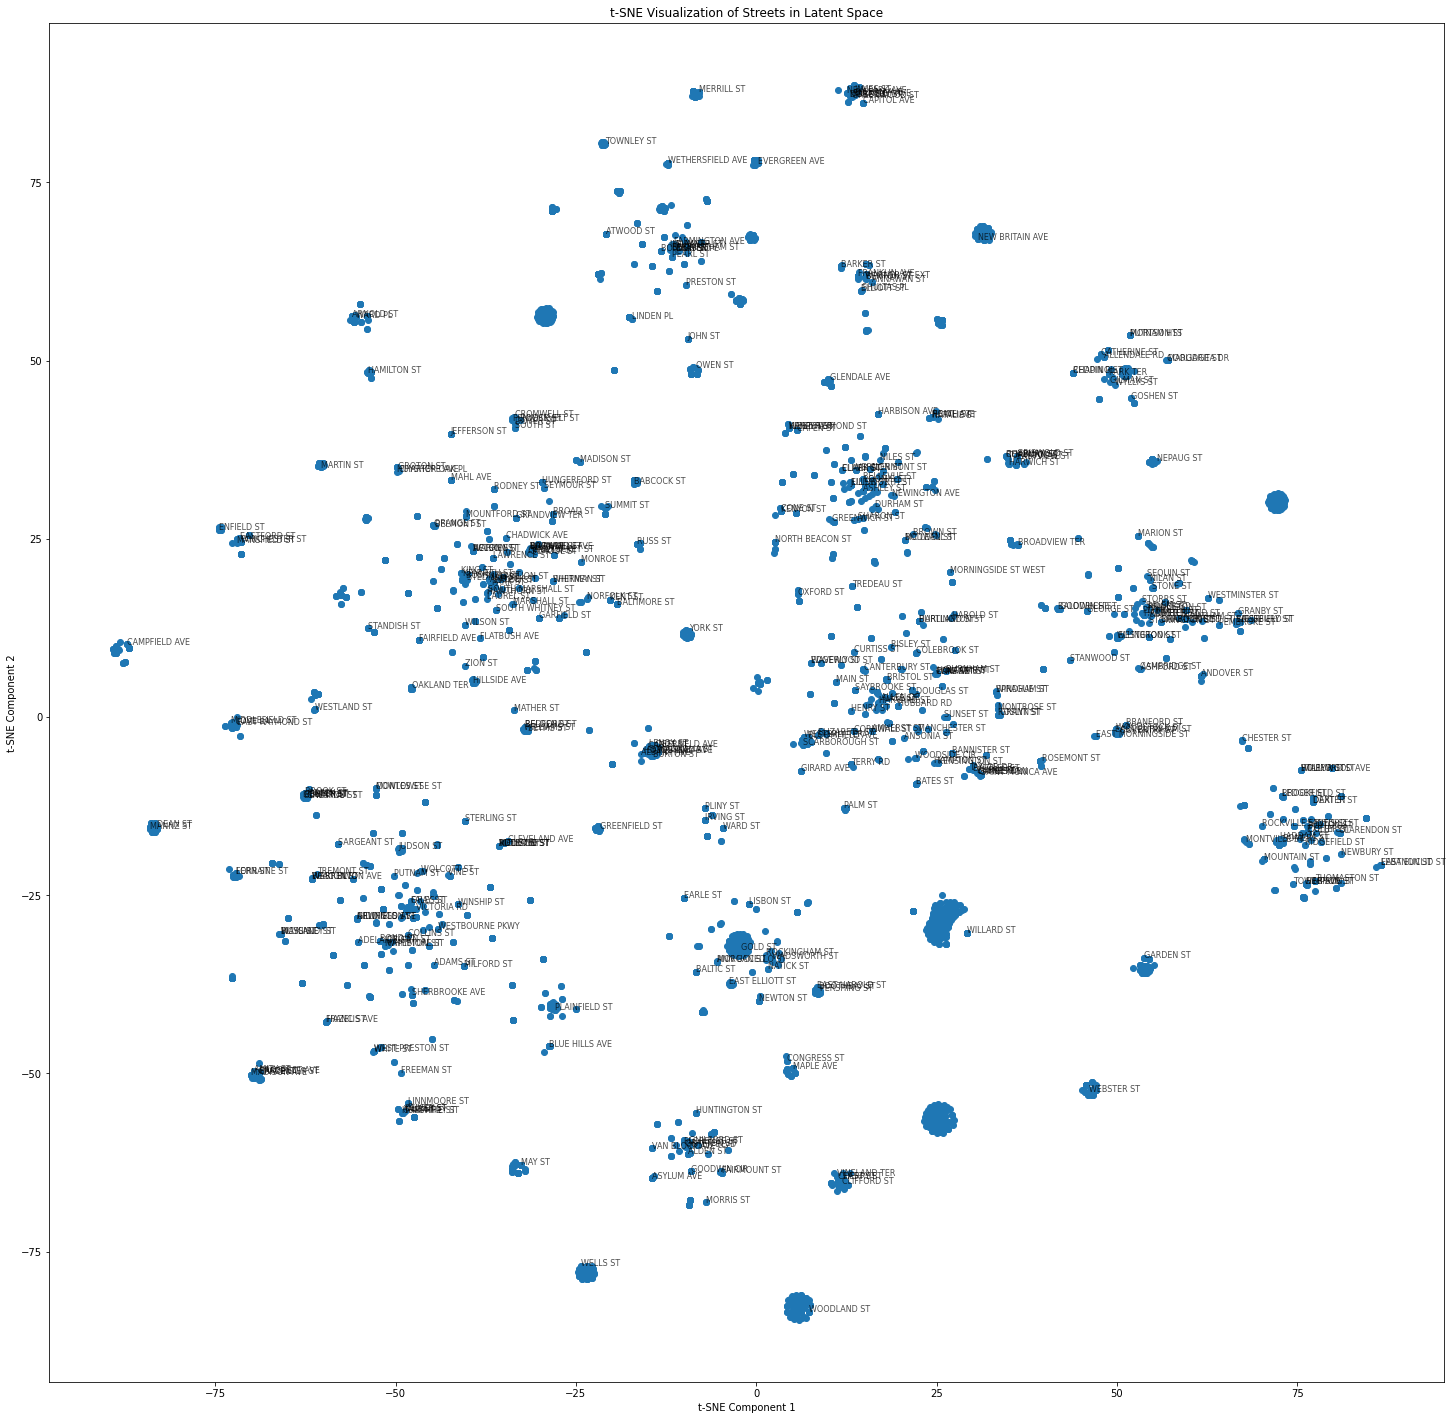

In [34]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Extract the StreetNameAndWay column for annotations
street_names = df_encoded['StreetNameAndWay'].tolist()

# Apply t-SNE on the latent features of streets (W matrix)
tsne_model = TSNE(n_components=2, random_state=0)
tsne_embedding = tsne_model.fit_transform(W)

# Visualization
plt.figure(figsize=(25, 25))
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1])

# Annotate the points with street names
met_streets = []
cn = 0
for i, street_name in enumerate(street_names):
    if street_name in met_streets:
        continue
    met_streets.append(street_name)

    plt.annotate(street_name, (tsne_embedding[i, 0], tsne_embedding[i, 1]), fontsize=8, alpha=0.7)
    
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Streets in Latent Space')
plt.show()


#### Find clusters of streets and save them to a list of lists 

In [35]:
# Apply DBSCAN to t-SNE embeddings
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(tsne_embedding)

# Create clusters
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # '-1' denotes noise in DBSCAN

clusters = {i: [] for i in range(n_clusters)}

for street_name, label in zip(street_names, labels):
    if label != -1 and street_name not in clusters[label]:
        clusters[label].append(street_name)

#### Represent few random clusters of streets on a map

In [36]:
def nominatim_geocode(address):
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": address,
        "format": "json"
    }
    headers = {
        "User-Agent": "your_email@example.com"  # Replace this with your email
    }
    response = requests.get(base_url, params=params, headers=headers)
    data = response.json()
    if data:
        return float(data[0]['lat']), float(data[0]['lon'])
    else:
        return None

def visualize_street_clusters(clusters):
    # Filter clusters based on size
    clusters = list(clusters.values())
    valid_clusters = [cluster for cluster in clusters if 4 < len(cluster) and len(cluster) <= 10]
    
    # Select up to 5 clusters
    selected_clusters = valid_clusters[:7]

    # Create a map
    m = folium.Map(location=[41.7658, -72.6734], zoom_start=14)  # Default to Hartford's coordinates
    
    # Define colors
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightblue']

    i = 0
    for cluster in selected_clusters:
        i += 1
        print("cluster ",i)
        cluster_color = colors.pop(0)  # Get and remove the first color

        for street in cluster:
            address = f"{street}, Hartford, CT"
            coordinates = nominatim_geocode(address)
            if coordinates:
                folium.Marker(coordinates, tooltip=street, icon=folium.Icon(color=cluster_color)).add_to(m)
                time.sleep(1)  # Respect the rate limit of the API

    # Save the map to an HTML file
    m.save("clusters_map.html")
    return valid_clusters,selected_clusters

# Example usage:

valid_clusters,selected_clusters = visualize_street_clusters(clusters)


cluster  1
cluster  2
cluster  3
cluster  4
cluster  5
cluster  6
cluster  7
